In [1]:
import pandas as pd
import numpy as np

# Packages untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)

# LOAD DAN MENAMPILKAN DATASET

In [6]:
ctcovid = pd.read_csv("GLCM_Covid.csv");
ctcovid.head()

,label,CONTRAST0,HOMOGENITY0,ENTROPY0,ENERGY0,CONTRAST45,HOMOGENITY45,ENTROPY45,ENERGY45,CONTRAST90,HOMOGENITY90,ENTROPY90,ENERGY90,CONTRAST135,HOMOGENITY135,ENTROPY135,ENERGY135
0,1,4.552288,0.644010,3.614979,0.064522,5.095604,0.625877,3.652356,0.061951,2.174151,0.688930,3.455847,0.070650,5.091636,0.630201,3.652590,0.062272
1,1,3.300935,0.784967,3.011608,0.173187,5.322401,0.753999,3.127794,0.164812,4.346580,0.770280,3.072447,0.168263,5.823920,0.748377,3.145396,0.163226
2,1,3.328125,0.785723,2.971865,0.182995,5.372869,0.754217,3.086182,0.175032,4.362943,0.770463,3.032681,0.178490,5.849836,0.751010,3.097675,0.173615
3,1,3.432579,0.786071,2.945866,0.189870,5.390663,0.755853,3.051266,0.182225,4.253875,0.774015,2.994296,0.186306,5.711513,0.754291,3.060028,0.181271
4,1,3.374446,0.779573,2.947369,0.200533,5.000062,0.755515,3.034623,0.194259,3.779897,0.774639,2.965557,0.198529,5.296671,0.753300,3.043882,0.192846


In [5]:
data = np.array(ctcovid[['CONTRAST0','HOMOGENITY0','ENTROPY0','ENERGY0','CONTRAST45','HOMOGENITY45','ENTROPY45','ENERGY45','CONTRAST90','HOMOGENITY90','ENTROPY90','ENERGY90','CONTRAST135','HOMOGENITY135','ENTROPY135','ENERGY135']])
label = np.array(ctcovid['label'])

# MEMERIKSA DATA

melakukan pemeriksaan jika terdapat record / field yang
tidak layak dipakai, seperti record / field yang bernilai NaN atau field
yang berbentuk kategori 

In [4]:
ctcovid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
label            200 non-null int64
CONTRAST0        200 non-null float64
HOMOGENITY0      200 non-null float64
ENTROPY0         200 non-null float64
ENERGY0          200 non-null float64
CONTRAST45       200 non-null float64
HOMOGENITY45     200 non-null float64
ENTROPY45        200 non-null float64
ENERGY45         200 non-null float64
CONTRAST90       200 non-null float64
HOMOGENITY90     200 non-null float64
ENTROPY90        200 non-null float64
ENERGY90         200 non-null float64
CONTRAST135      200 non-null float64
HOMOGENITY135    200 non-null float64
ENTROPY135       200 non-null float64
ENERGY135        200 non-null float64
dtypes: float64(16), int64(1)
memory usage: 26.6 KB


# PCA

algoritma PCA di-coding menjadi fungsi dengan Input features vektor yang akan ditransformasikan (dt) dan jumlah eigen yang dipilih (nEigen). nEigen sangat menentukan dalam PCA karena features vektor input (m dimensi) akan direduksi menjadi nEgien dimensi.

In [7]:
from numpy import linalg as LA

In [11]:
def myPCA(data,nEigen):
    #1 Def global mean, mu
    mu=np.mean(data,axis=0)

    #2. Determine diff=dt-mu
    nR=data.shape[0] #get row size 
    diff=np.array(data) #makes a copy
    for i in range (nR):
        diff[i,:]=diff[i,:]-mu
        
    #3. Get Covariance Matrix, S    
    A=np.transpose(data)@data  #Matrix multiplication

    #4. Get Eigen
    w, v = LA.eig(A)

    #5. get W
    idx=np.argsort(-w)
    Ww=v[:,idx[0:nEigen]]
    
    #6. Projection
    dP=diff@Ww
    
    return mu, Ww, dP;

Sebelum proses klasifikasi data input (dt), dt dikurangi jumlah dimensinya menggunakan fungsi PCA diatas . selanjutnya sebaran data digambarkan kedalam ruang 3 dimensi dan 2 dimensi dengan code berikut maka diperoleh hasil sebaran sbb:

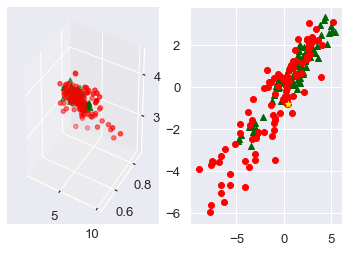

In [12]:
#1. Dimensional Reduction
mu, Ww, dP=myPCA(data,2)

#2. plot the data in 3D space
from mpl_toolkits.mplot3d import Axes3D
#Show the plot of Projection 
#Initialize the plot
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

# Plot the data

#class 1
idx = np.where(label == 0)
t0=data[idx[0],:]
ax1.scatter(t0[:,0],t0[:,1],t0[:,2], color='darkgreen', marker='^')
t=dP[idx[0],:]
ax2.scatter(t[:,0],t[:,1],color='darkgreen', marker='^')

#class 2
idx = np.where(label == 1)
t0=data[idx[0],:]
ax1.scatter(t0[:,0],t0[:,1],t0[:,2], color='red', marker='o')
t=dP[idx[0],:]
ax2.scatter(t[:,0],t[:,1],color='red', marker='o')

#unknown class
tQ=[3.432579,0.786071,2.945866,0.189870,5.390663,0.755853,3.051266,0.182225,4.253875,0.774015,2.994296,0.186306,5.711513,0.754291,3.060028,0.181271]
ax1.scatter(tQ[0],tQ[1],tQ[2], color='yellow', marker='*')

tQP=(tQ-mu)@Ww
ax2.scatter(tQP[0],tQP[1], color='yellow', marker='*')

# Show the plot
plt.show()

# KLASIFIKASI SVM

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [17]:

def generateClassificationReport(y_test,y_pred):
    print(classification_report(y_test,y_pred))
    print("confusion matiksnya sebagai berikut :  \n",confusion_matrix(y_test,y_pred))    
    print('accuracy is ',accuracy_score(y_test,y_pred))
# Create support vector classifier
SVC_Classifier = LinearSVC(C=1)
# Train model
SVC_Classifier.fit(dP,label)
#Prediction
y_pred = SVC_Classifier.predict(dP)
generateClassificationReport(label,y_pred)

              precision    recall  f1-score   support

           0       0.64      0.76      0.69       100
           1       0.70      0.57      0.63       100

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.66       200
weighted avg       0.67      0.67      0.66       200

confusion matiksnya sebagai berikut :  
 [[76 24]
 [43 57]]
accuracy is  0.665


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


menggambarkan matriks dalam ruang data yang kita miliki :

In [21]:
h = .02
x_min, x_max = dP[:, 0].min() - 1, dP[:, 0].max() + 1
y_min, y_max = dP[:, 1].min() - 1, dP[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [22]:
#Predict the mesh of data using SVM
Z =  SVC_Classifier.predict(np.c_[xx.ravel(),  yy.ravel()])
Z = Z.reshape(xx.shape)

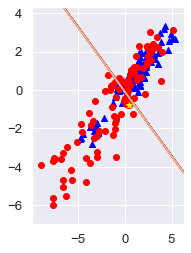

In [24]:
#Visualize the classification line of Linear SVM
#Show the plot of Projection 
#Initialize the plot
fig = plt.figure()
ax2 = fig.add_subplot(122)

# Plot the data

#class 1
idx = np.where(label == 0)
t=dP[idx[0],:]
ax2.scatter(t[:,0],t[:,1],color='blue', marker='^')

#class 2
idx = np.where(label == 1)
t=dP[idx[0],:]
ax2.scatter(t[:,0],t[:,1],color='red', marker='o')

#unknown class
tQ=[3.432579,0.786071,2.945866,0.189870,5.390663,0.755853,3.051266,0.182225,4.253875,0.774015,2.994296,0.186306,5.711513,0.754291,3.060028,0.181271]
tQP=(tQ-mu)@Ww
ax2.scatter(tQP[0],tQP[1], color='yellow', marker='*')
plt.contour(xx, yy, Z)
# Show the plot
plt.show()

klasifikasi data tQ=[3.432579,0.786071,2.945866,0.189870,5.390663,0.755853,3.051266,0.182225,4.253875,0.774015,2.994296,0.186306,5.711513,0.754291,3.060028,0.181271] dengan menggunakan model SVM yang sudah diperoleh sebelumnya dengan cara :

In [26]:
prediksi = SVC_Classifier.predict(tQP.reshape(1,-1))
print("data baru dikenali sebagai : ", prediksi)

data baru dikenali sebagai :  [1]
